In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt

In [53]:
from unagi import hsc
from unagi import mask
from unagi import config
from unagi import plotting
from unagi.task import hsc_cutout

s18a = hsc.Hsc(dr='dr2', rerun='s18a_wide')

### Example of a mask plane

In [428]:
# Download an example mask plane
coord = SkyCoord(150.0913, 2.2059, frame='icrs', unit='deg')

cutout_test = hsc_cutout(coord, cutout_size=20.0 * u.arcsec, filters='i', archive=s18a, 
                         use_saved=False, verbose=True, save_output=False, mask=True)

# Retrieving cutout image in filter: i


#### "Library" of mask planes

* HSC data reduced by different versions of `hscPipe` have different number and definitions for the bitmask planes. 
* For example, `PDR1` has 16 allowed bitmask planes, while internal `DR2` has 32 mask planes.  
* Not all mask planes are used, some of them are just placeholders for future usage.

In [417]:
# BitMasks class holds information about the mask planes for a given dataset. 
s18a_mask = mask.BitMasks(data_release='s18a')

s18a_mask.show_table()

idx,bits,name,meaning,color,value
0,0,BAD,Bad pixel,red,1
1,1,SAT,Source footprint includes saturated pixels,tab:purple,2
2,2,INTRP,Source footprint includes interpolated pixels,tab:orange,4
3,3,CR,Source footprint includes suspected CR pixels,tab:pink,8
4,4,EDGE,Source is close to the edge of the CCD,tab:olive,16
5,5,DETECTED,Pixel with detection above the threshold,tab:blue,32
6,6,DETECTED_NEGATIVE,Pixel in footprint that is detected as a negative object,gray,64
7,7,SUSPECT,Source footprint includes suspect pixels,orangered,128
8,8,NO_DATA,No useful data,black,256
9,9,BRIGHT_OBJECT,Bright star mask,tab:brown,512


#### Using the HSC mask plane 

* `mask` locates in the 2nd HDU of a HSC coadd image.

In [426]:
bitmask = cutout_test[2].data

mask_test = mask.Mask(bitmask, data_release='s18a')

#### Extract a single layer of mask 

* Use the `extract()` method, you can use the name of the mask plane or the bit value as input
* Default output format is `np.uint8` (pixel value 1 means masked, 0 means unmasked).
* The `show=True` option will return a `np.uint16` version of the mask array to display
* You can display this layer of mask using the `display()` method.

In [439]:
mask_1 = mask_test.extract('DETECTED')
mask_2 = mask_test.extract(5)

assert np.all(mask_1 == mask_2)

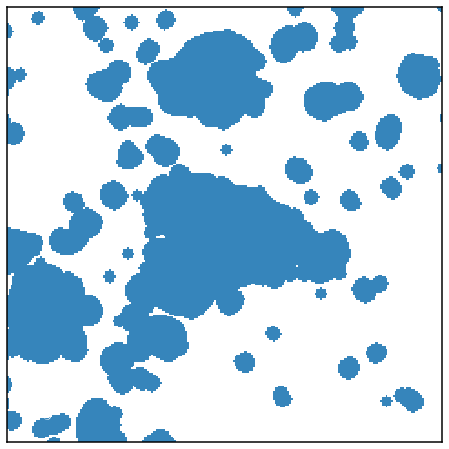

In [441]:
_ = mask_test.display('DETECTED')

* It is also possible to extract or display multiple layers of masks at the same time

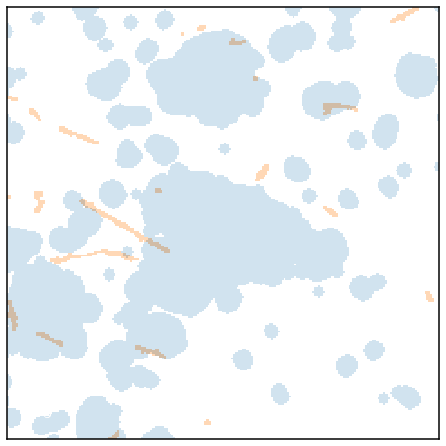

In [449]:
mask_3 = mask_test.extract(['DETECTED', 'INTRP', 'SAT'])

_ = mask_test.display(['DETECTED', 'INTRP', 'SAT'], alpha_list=[1.0, 0.6, 0.5])

#### Combine multiple layers of masks

#### Remove one or multiple layers of masks

In [99]:
%%timeit 

mask_test = mask.Mask(bitmask)

3.14 ms ± 36.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [152]:
s18a_mask = mask.BitMasks(data_release='s18a')

mask_test = mask.Mask(bitmask)

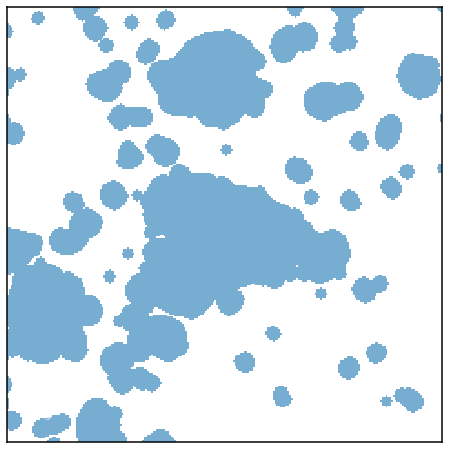

In [134]:
_ = plotting.display_single(mask_test.extract('DETECTED', show=True), 
                            scale='linear', cmap=mask_test.mask_cmap('DETECTED'), 
                            alpha=0.6)

In [126]:
%%timeit

_ = mask_test.extract('INTRP')

6.77 µs ± 191 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


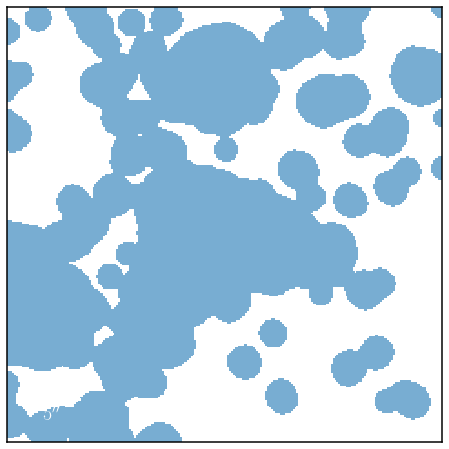

In [138]:
_ = plotting.display_single(mask_test.enlarge('DETECTED').astype(float), 
                            scale='linear', cmap=mask_test.mask_cmap('DETECTED'), 
                            alpha=0.6)

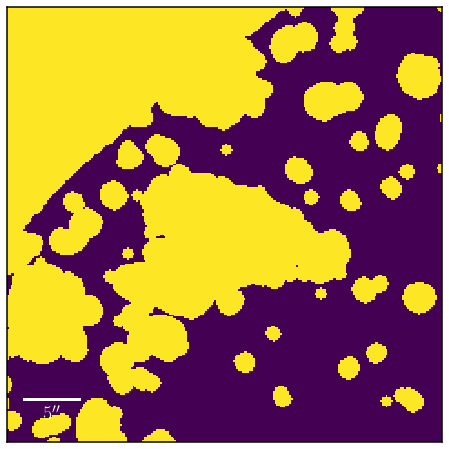

In [147]:
ll = [mask_test.extract('DETECTED'), mask_test.extract('CLIPPED'), mask_test.extract('SAT')]

np.bitwise_or.reduce(ll)
_ = plotting.display_single(
    np.bitwise_or.reduce(ll).astype(float), scale='linear')

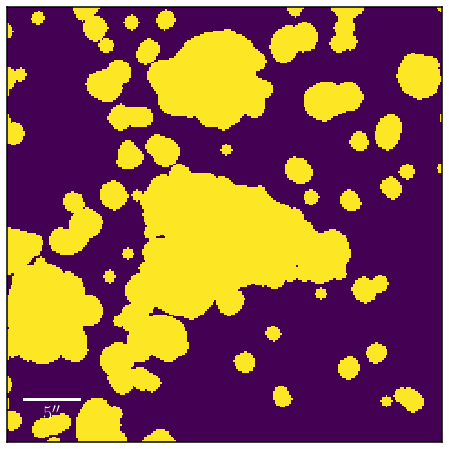

In [151]:
_ = plotting.display_single((mask_test.combine(['DETECTED'])).astype(float), scale='linear')

In [185]:
mask_test.clean(['DETECTED', 'BAD']).astype(float).shape

(239, 239)

In [183]:
aa = np.delete(mask_test.masks, (2), axis=2)

In [169]:
mask_test = mask.Mask(bitmask)

In [193]:
a = [mask_test.masks[:, :, ii].sum() > 0 for ii in np.arange(mask_test.masks.shape[2])]

In [196]:
np.sum(a)

7

In [199]:
mask_test.masks[:, :, a]

(239, 239, 7)

In [202]:
mask_test.table

array([( 0, 'BAD', 'Bad pixel', 'red'),
       ( 1, 'SAT', 'Source footprint includes saturated pixels', 'tab:purple'),
       ( 2, 'INTRP', 'Source footprint includes interpolated pixels', 'tab:orange'),
       ( 3, 'CR', 'Source footprint includes suspected CR pixels', 'tab:pink'),
       ( 4, 'EDGE', 'Source is close to the edge of the CCD', 'tab:olive'),
       ( 5, 'DETECTED', 'Pixel with detection above the threshold', 'tab:blue'),
       ( 6, 'DETECTED_N', 'Pixel in footprint that is detected as a negative object', 'gray'),
       ( 7, 'SUSPECT', 'Source footprint includes suspect pixels', 'orangered'),
       ( 8, 'NO_DATA', 'No useful data', 'black'),
       ( 9, 'BRIGHT_OBJ', 'Bright star mask', 'tab:brown'),
       (10, 'CROSSTALK', 'Crosstalk', 'rosybrown'),
       (11, 'NOT_DEBLEN', 'Pixel in footprint that is too large to deblend', 'teal'),
       (12, 'UNMASKEDNA', 'NaN pixels that are interpolated over', 'darkgreen'),
       (13, 'REJECTED', 'Rejected due to a mask othe

In [210]:
np.unpackbits(bitmask.view(np.uint8), axis=1).shape

(239, 3824)

In [239]:
bitmask = cutout_test[2].data
bitmask.max()

106528.0

In [218]:
mask_test.masks[:, :, 15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [230]:
2 ** 16

65536

In [220]:
bitmask += 2**16

In [240]:
mask_test.decode(bitmask).shape

(239, 239, 64)

In [223]:
bitmask

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [24576, 24576, 24576, ...,  8192,  8192,  8224],
       [24576, 24576, 24576, ...,  8192,  8224,  8224],
       [24576, 24576, 24576, ...,  8224,  8224,  8224]], dtype=uint16)

In [224]:
bitmask = bitmask + (2**16)

In [345]:
def decode(bitmask):
    '''
    Convert HSC binary mask to a 3-D array,
    with binary digits located in the third axis.

    Parameters:
    -----------
    bin_msk: 2-D np.array, can be loaded from HSC image cutouts

    The code is based on convert_HSC_binary_mask() function by Jia-Xuan Li
    see: https://github.com/AstroJacobLi/slug/blob/master/slug/imutils.py
    '''
    temp = np.array(
        np.hsplit(np.unpackbits(bitmask.view(np.uint8), axis=1), bitmask.shape[1]))

    decode_mask = np.flip(np.transpose(
        np.concatenate(np.flip(np.array(np.dsplit(temp, 2)), axis=0), axis=2),
        axes=(1, 0, 2)), axis=2)

    return decode_mask

In [406]:
bitmask = cutout_test[2].data

a = decode(np.array(bitmask, dtype=np.uint32))

a.shape

(239, 239, 32)

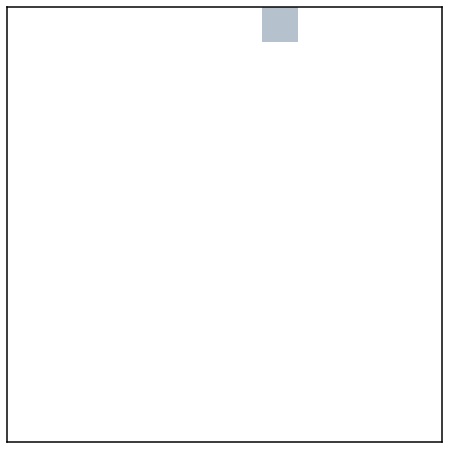

In [409]:
_ = plotting.display_single(a[:, :, 1].astype(float), 
                            scale='linear', cmap=mask_cmap, alpha=0.6)

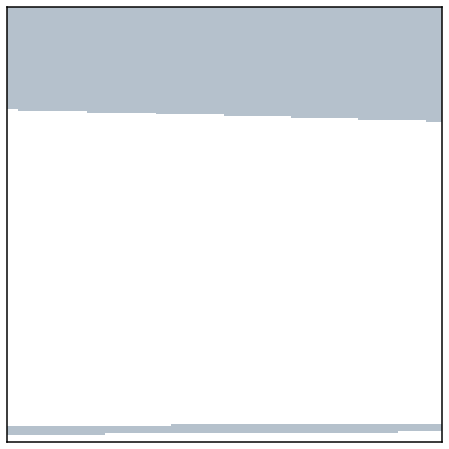

In [410]:
_ = plotting.display_single(a[:, :, 5].astype(float), 
                            scale='linear', cmap=mask_cmap, alpha=0.6)

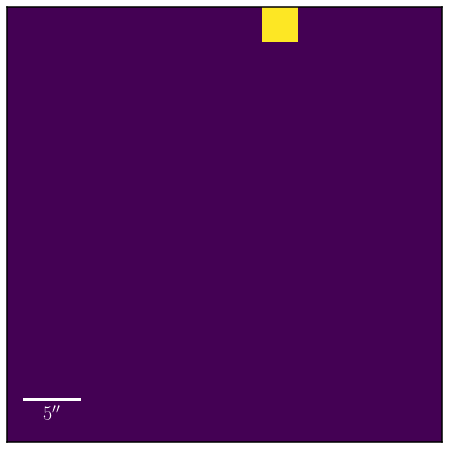

In [415]:
_ = plotting.display_single(
    bitmask.astype(np.uint32) & (2 ** 9), scale='linear')